# ShuffleNet V2 - PneumoniaMNIST Binary Classification

**Dataset:** PneumoniaMNIST (MedMNIST) — Normal vs Pneumonia
**Model:** ShuffleNet V2 x1.0 (pretrained on ImageNet)
**Task:** Binary classification (CrossEntropyLoss)

**Outputs:** class distribution · sample grids · training curves · confusion matrices (val+test) · ROC curves · per-class metrics · CSV report


In [1]:
!pip install transformers>=4.38
!pip install medmnist          # only needed for PneumoniaMNIST
!pip install torchinfo         # optional — for model summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.8 MB/s eta 0:00:00


In [2]:
import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T
import torchvision.models as models

try:
    import medmnist
    print(f"MedMNIST : {medmnist.__version__}")
except ImportError:
    os.system("pip install -q medmnist")
    import medmnist

from medmnist import PneumoniaMNIST, INFO

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score,
    f1_score, precision_score, recall_score,
)
from sklearn.preprocessing import label_binarize

print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")


MedMNIST : 3.0.2
PyTorch : 2.10.0+cu128
CUDA    : True
GPU     : Tesla T4
VRAM    : 15.6 GB


In [3]:
class Config:
    DATA_DIR   = "/kaggle/working/medmnist"
    OUTPUT_DIR = "/kaggle/working"
    PREFIX     = "shufflenet_pm"
    MODEL_NAME = "ShuffleNet V2"

    NUM_CLASSES = 2
    CLASS_NAMES = ["Normal", "Pneumonia"]
    SHORT_NAMES = ["Normal", "Pneumonia"]

    BATCH_SIZE    = 32
    NUM_EPOCHS    = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY  = 1e-5
    IMG_SIZE      = 224

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED   = 42

cfg = Config()
os.makedirs(cfg.DATA_DIR, exist_ok=True)

def set_seed(s):
    np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"Device  : {cfg.DEVICE}")
print(f"Model   : {cfg.MODEL_NAME}")
print(f"Classes : {cfg.CLASS_NAMES}")


Device  : cuda
Model   : ShuffleNet V2
Classes : ['Normal', 'Pneumonia']


## Data Exploration

Task      : binary-class
n_channels: 1
n_samples : {'train': 4708, 'val': 524, 'test': 624}
Labels    : {'0': 'normal', '1': 'pneumonia'}


100%|██████████| 214M/214M [00:04<00:00, 53.3MB/s]


Download size: 224x224
  Train  — Normal:1214  Pneumonia:3494  Total:4708
  Val    — Normal:135  Pneumonia:389  Total:524
  Test   — Normal:234  Pneumonia:390  Total:624


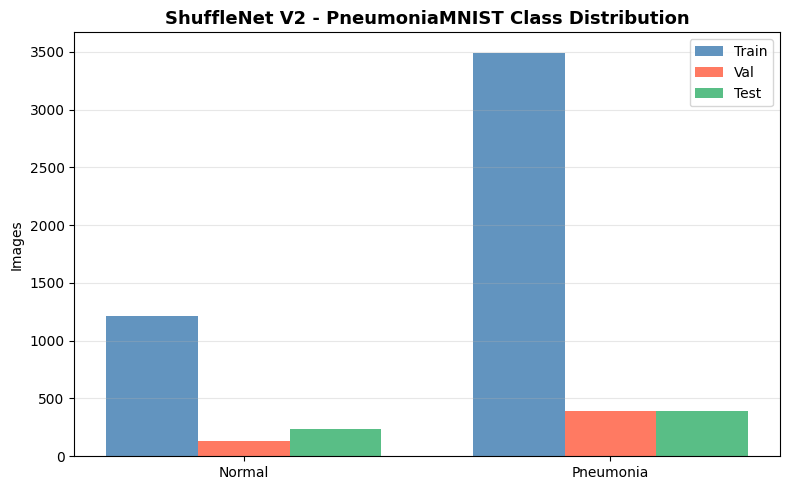

In [4]:
info = INFO["pneumoniamnist"]
print("Task      :", info["task"])
print("n_channels:", info["n_channels"])
print("n_samples :", info["n_samples"])
print("Labels    :", info["label"])

# Download
try:
    _tmp = PneumoniaMNIST(split="train", download=True, size=224, root=cfg.DATA_DIR)
    NATIVE_SIZE = 224
except Exception:
    _tmp = PneumoniaMNIST(split="train", download=True, root=cfg.DATA_DIR)
    NATIVE_SIZE = 28
print(f"Download size: {NATIVE_SIZE}x{NATIVE_SIZE}")
del _tmp

split_counts = {}
for split in ["train", "val", "test"]:
    try:
        ds = PneumoniaMNIST(split=split, download=True, size=NATIVE_SIZE, root=cfg.DATA_DIR)
    except Exception:
        ds = PneumoniaMNIST(split=split, download=True, root=cfg.DATA_DIR)
    labels_flat = [int(ds.labels[i][0]) for i in range(len(ds))]
    cnt = Counter(labels_flat)
    split_counts[split.capitalize()] = [cnt.get(0,0), cnt.get(1,0)]
    print(f"  {split.capitalize():6s} — Normal:{cnt.get(0,0)}  Pneumonia:{cnt.get(1,0)}  Total:{len(ds)}")

x = np.arange(len(cfg.CLASS_NAMES)); w = 0.25
clrs = ["steelblue", "tomato", "mediumseagreen"]
fig, ax = plt.subplots(figsize=(8, 5))
for i, (split, color) in enumerate(zip(["Train","Val","Test"], clrs)):
    ax.bar(x + i*w, split_counts[split], w, label=split, color=color, alpha=0.85)
ax.set_xticks(x + w); ax.set_xticklabels(cfg.CLASS_NAMES)
ax.set_ylabel("Images")
ax.set_title(f"{cfg.MODEL_NAME} - PneumoniaMNIST Class Distribution", fontsize=13, fontweight="bold")
ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_class_distribution.png"), dpi=150, bbox_inches="tight")
plt.show()


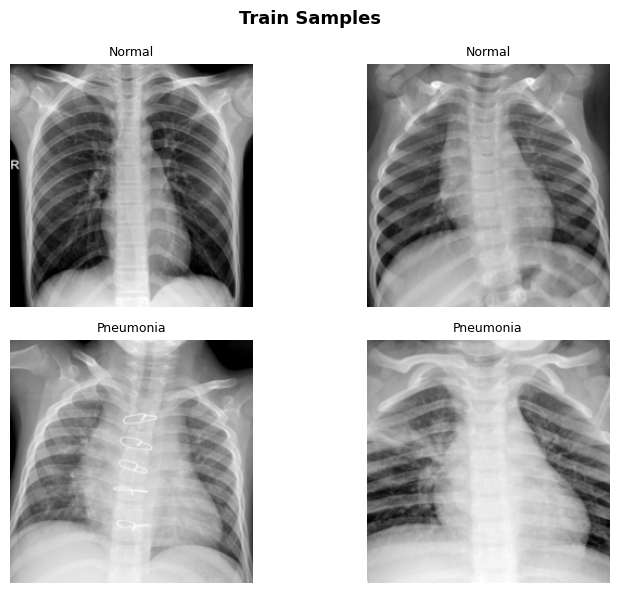

100%|██████████| 4.17M/4.17M [00:00<00:00, 29.3MB/s]


ValueError: 

In [5]:
def show_sample_grid(split_name, n=2):
    try:
        ds = PneumoniaMNIST(split=split_name.lower(), download=True, size=NATIVE_SIZE, root=cfg.DATA_DIR)
    except Exception:
        ds = PneumoniaMNIST(split=split_name.lower(), download=True, root=cfg.DATA_DIR)
    class_indices = {0:[], 1:[]}
    for i in range(len(ds)):
        lbl = int(ds.labels[i][0])
        if len(class_indices[lbl]) < n:
            class_indices[lbl].append(i)
    fig, axes = plt.subplots(2, n, figsize=(n*4, 6))
    fig.suptitle(f"{split_name} Samples", fontsize=13, fontweight="bold")
    for row, (cls_idx, idxs) in enumerate(class_indices.items()):
        for col, img_idx in enumerate(idxs):
            img_arr, _ = ds[img_idx]
            ax = axes[row, col]
            ax.imshow(img_arr, cmap="gray")
            ax.set_title(cfg.CLASS_NAMES[cls_idx], fontsize=9)
            ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_samples_{split_name.lower()}.png"), dpi=120, bbox_inches="tight")
    plt.show()

show_sample_grid("Train")
show_sample_grid("Validation")
show_sample_grid("Test")


## Dataset & DataLoaders

In [6]:
# Transforms — only what the model needs: resize + ToTensor + Normalize
# No augmentation on any split
transform = T.Compose([
    T.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    T.Grayscale(num_output_channels=3),   # ShuffleNet expects 3-channel input
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class PneumoniaMNISTDataset(Dataset):
    def __init__(self, split, transform=None):
        try:
            self.base = PneumoniaMNIST(split=split, download=True, size=NATIVE_SIZE, root=cfg.DATA_DIR)
        except Exception:
            self.base = PneumoniaMNIST(split=split, download=True, root=cfg.DATA_DIR)
        self.transform = transform

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        img, label_arr = self.base[idx]
        label = int(label_arr[0])
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = PneumoniaMNISTDataset("train", transform=transform)
val_ds   = PneumoniaMNISTDataset("val",   transform=transform)
test_ds  = PneumoniaMNISTDataset("test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train:{len(train_ds)}  Val:{len(val_ds)}  Test:{len(test_ds)}")


Train:4708  Val:524  Test:624


## Model — ShuffleNet V2

In [7]:
backbone = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
# Replace final classifier (1024 -> num_classes)
backbone.fc = nn.Linear(backbone.fc.in_features, cfg.NUM_CLASSES)
model = backbone.to(cfg.DEVICE)

total_p    = sum(p.numel() for p in model.parameters())
trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params     : {total_p:,}")
print(f"Trainable params : {trainable_p:,}  ({100*trainable_p/total_p:.1f}%)")


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 48.4MB/s]


Total params     : 1,255,654
Trainable params : 1,255,654  (100.0%)


## Loss / Optimizer / Scheduler

In [8]:
train_labels_all = [int(train_ds.base.labels[i][0]) for i in range(len(train_ds))]
counts  = np.bincount(train_labels_all, minlength=cfg.NUM_CLASSES).astype(float)
weights = torch.tensor(1.0 / (counts + 1e-6), dtype=torch.float32)
weights = (weights / weights.sum() * cfg.NUM_CLASSES).to(cfg.DEVICE)
print("Class weights:", weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS, eta_min=1e-7)
print(f"LR={cfg.LEARNING_RATE}  Weight Decay={cfg.WEIGHT_DECAY}")


Class weights: [1.484282  0.5157179]
LR=0.0001  Weight Decay=1e-05


## Training Loop

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for pv, labels in tqdm(loader, desc="Train", leave=False):
        pv, labels = pv.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(pv)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * pv.size(0)
        correct      += (logits.argmax(1) == labels).sum().item()
        total        += pv.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_probs, all_preds, all_labels = [], [], []
    for pv, labels in tqdm(loader, desc="Eval ", leave=False):
        pv, labels = pv.to(device), labels.to(device)
        logits = model(pv)
        loss   = criterion(logits, labels)
        probs  = torch.softmax(logits, dim=1)
        preds  = probs.argmax(1)
        running_loss += loss.item() * pv.size(0)
        correct      += (preds == labels).sum().item()
        total        += pv.size(0)
        all_probs.append(probs.cpu()); all_preds.append(preds.cpu()); all_labels.append(labels.cpu())
    return (running_loss / total, correct / total,
            torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())


In [10]:
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
best_val_loss   = float("inf")
best_model_path = os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_best.pth")

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)
    va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, cfg.DEVICE)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    tag = "  <- saved" if va_loss < best_val_loss else ""
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model.state_dict(), best_model_path)
    print(f"Epoch [{epoch:02d}/{cfg.NUM_EPOCHS}]  Train Loss={tr_loss:.4f} Acc={tr_acc:.4f}  |  Val Loss={va_loss:.4f} Acc={va_acc:.4f}{tag}")

print(f"\nBest val loss: {best_val_loss:.4f}")


Epoch [01/25]  Train Loss=0.4344 Acc=0.8263  |  Val Loss=0.2047 Acc=0.9618  <- saved


Epoch [02/25]  Train Loss=0.1439 Acc=0.9709  |  Val Loss=0.0968 Acc=0.9771  <- saved


Epoch [03/25]  Train Loss=0.0772 Acc=0.9839  |  Val Loss=0.0689 Acc=0.9828  <- saved


Epoch [04/25]  Train Loss=0.0421 Acc=0.9926  |  Val Loss=0.0554 Acc=0.9847  <- saved


Epoch [05/25]  Train Loss=0.0357 Acc=0.9917  |  Val Loss=0.0650 Acc=0.9828


Epoch [06/25]  Train Loss=0.0183 Acc=0.9970  |  Val Loss=0.0664 Acc=0.9847


Epoch [07/25]  Train Loss=0.0206 Acc=0.9953  |  Val Loss=0.0575 Acc=0.9809


Epoch [08/25]  Train Loss=0.0080 Acc=0.9996  |  Val Loss=0.0539 Acc=0.9809  <- saved


Epoch [09/25]  Train Loss=0.0142 Acc=0.9970  |  Val Loss=0.0505 Acc=0.9866  <- saved


Epoch [10/25]  Train Loss=0.0079 Acc=0.9985  |  Val Loss=0.0465 Acc=0.9866  <- saved


Epoch [11/25]  Train Loss=0.0053 Acc=0.9994  |  Val Loss=0.0495 Acc=0.9847


Epoch [12/25]  Train Loss=0.0041 Acc=0.9998  |  Val Loss=0.0522 Acc=0.9866


Epoch [13/25]  Train Loss=0.0065 Acc=0.9989  |  Val Loss=0.0638 Acc=0.9847


Epoch [14/25]  Train Loss=0.0048 Acc=0.9994  |  Val Loss=0.0512 Acc=0.9885


Epoch [15/25]  Train Loss=0.0039 Acc=0.9994  |  Val Loss=0.0533 Acc=0.9847


Epoch [16/25]  Train Loss=0.0024 Acc=1.0000  |  Val Loss=0.0532 Acc=0.9866


Epoch [17/25]  Train Loss=0.0028 Acc=1.0000  |  Val Loss=0.0542 Acc=0.9866


Epoch [18/25]  Train Loss=0.0023 Acc=0.9998  |  Val Loss=0.0514 Acc=0.9885


Epoch [19/25]  Train Loss=0.0024 Acc=0.9998  |  Val Loss=0.0526 Acc=0.9866


Epoch [20/25]  Train Loss=0.0032 Acc=0.9996  |  Val Loss=0.0601 Acc=0.9847


Epoch [21/25]  Train Loss=0.0018 Acc=1.0000  |  Val Loss=0.0606 Acc=0.9847


Epoch [22/25]  Train Loss=0.0020 Acc=1.0000  |  Val Loss=0.0578 Acc=0.9866


Epoch [23/25]  Train Loss=0.0025 Acc=0.9998  |  Val Loss=0.0531 Acc=0.9866


Epoch [24/25]  Train Loss=0.0017 Acc=1.0000  |  Val Loss=0.0599 Acc=0.9828


Epoch [25/25]  Train Loss=0.0019 Acc=0.9998  |  Val Loss=0.0612 Acc=0.9828

Best val loss: 0.0465


In [11]:
model.load_state_dict(torch.load(best_model_path, map_location=cfg.DEVICE))
print("Loaded best checkpoint.")
_, val_acc, val_probs, val_preds, val_labels = evaluate(model, val_loader,  criterion, cfg.DEVICE)
_, tst_acc, tst_probs, tst_preds, tst_labels = evaluate(model, test_loader, criterion, cfg.DEVICE)
print(f"Val  Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {tst_acc:.4f}")


Loaded best checkpoint.


Val  Accuracy: 0.9866
Test Accuracy: 0.9519


## Training Curves

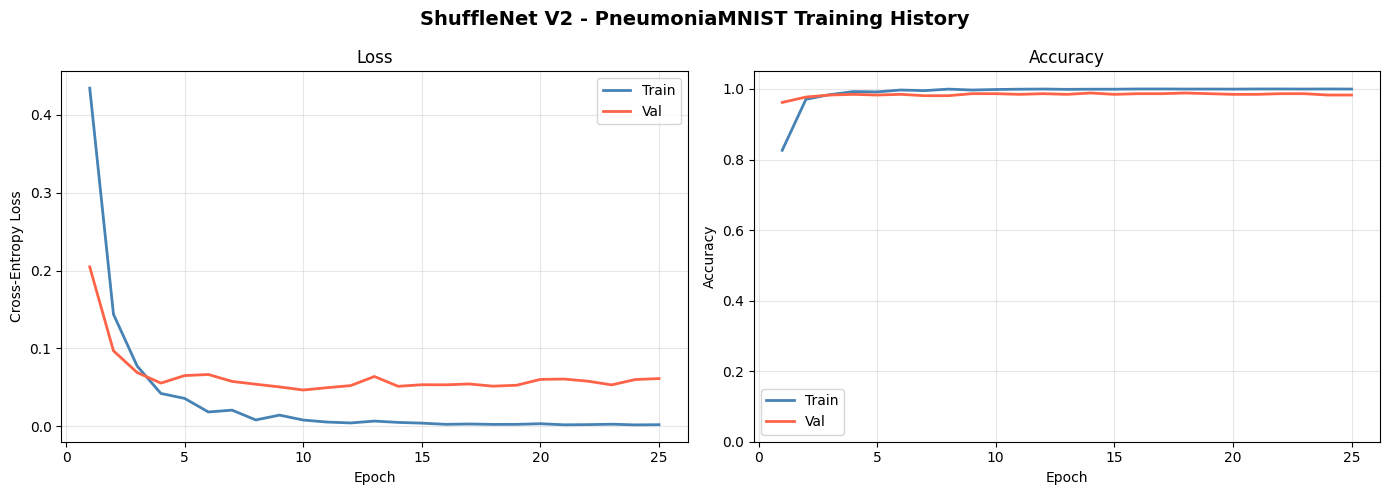

In [12]:
ep = range(1, cfg.NUM_EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f"{cfg.MODEL_NAME} - PneumoniaMNIST Training History", fontsize=14, fontweight="bold")
axes[0].plot(ep, history["train_loss"], label="Train", color="steelblue", lw=2)
axes[0].plot(ep, history["val_loss"],   label="Val",   color="tomato",    lw=2)
axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(ep, history["train_acc"], label="Train", color="steelblue", lw=2)
axes[1].plot(ep, history["val_acc"],   label="Val",   color="tomato",    lw=2)
axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1.05); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_training_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Confusion Matrices

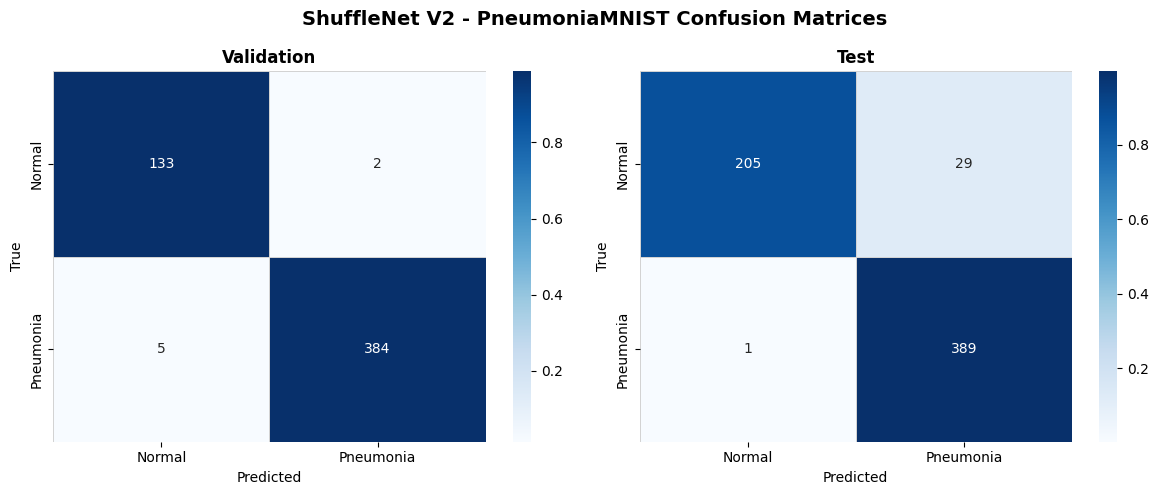

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"{cfg.MODEL_NAME} - PneumoniaMNIST Confusion Matrices", fontsize=14, fontweight="bold")
for ax, (preds, labels, title) in zip(axes, [
        (val_preds, val_labels, "Validation"),
        (tst_preds, tst_labels, "Test")]):
    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-6)
    sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues", ax=ax,
                xticklabels=cfg.CLASS_NAMES, yticklabels=cfg.CLASS_NAMES,
                linewidths=0.5, linecolor="lightgrey")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_confusion_matrices.png"), dpi=150, bbox_inches="tight")
plt.show()


## Classification Reports

In [14]:
reports = []
for split_name, preds, labels in [("Validation", val_preds, val_labels),
                                   ("Test",       tst_preds, tst_labels)]:
    print(f"\n{'='*60}\n  {split_name} Report\n{'='*60}")
    print(classification_report(labels, preds, target_names=cfg.CLASS_NAMES))
    for i, cls in enumerate(cfg.CLASS_NAMES):
        b_true = (labels == i).astype(int)
        b_pred = (preds  == i).astype(int)
        reports.append({
            "Split": split_name, "Class": cls,
            "Accuracy":  accuracy_score(b_true, b_pred),
            "Precision": precision_score(b_true, b_pred, zero_division=0),
            "Recall":    recall_score(b_true, b_pred, zero_division=0),
            "F1-Score":  f1_score(b_true, b_pred, zero_division=0),
        })

reports_df = pd.DataFrame(reports)
reports_df.to_csv(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_reports.csv"), index=False)
print(reports_df.to_string(index=False))



  Validation Report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       135
   Pneumonia       0.99      0.99      0.99       389

    accuracy                           0.99       524
   macro avg       0.98      0.99      0.98       524
weighted avg       0.99      0.99      0.99       524


  Test Report
              precision    recall  f1-score   support

      Normal       1.00      0.88      0.93       234
   Pneumonia       0.93      1.00      0.96       390

    accuracy                           0.95       624
   macro avg       0.96      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624

     Split     Class  Accuracy  Precision   Recall  F1-Score
Validation    Normal  0.986641   0.963768 0.985185  0.974359
Validation Pneumonia  0.986641   0.994819 0.987147  0.990968
      Test    Normal  0.951923   0.995146 0.876068  0.931818
      Test Pneumonia  0.951923   0.930622 0.997436  0.962871


## ROC Curves

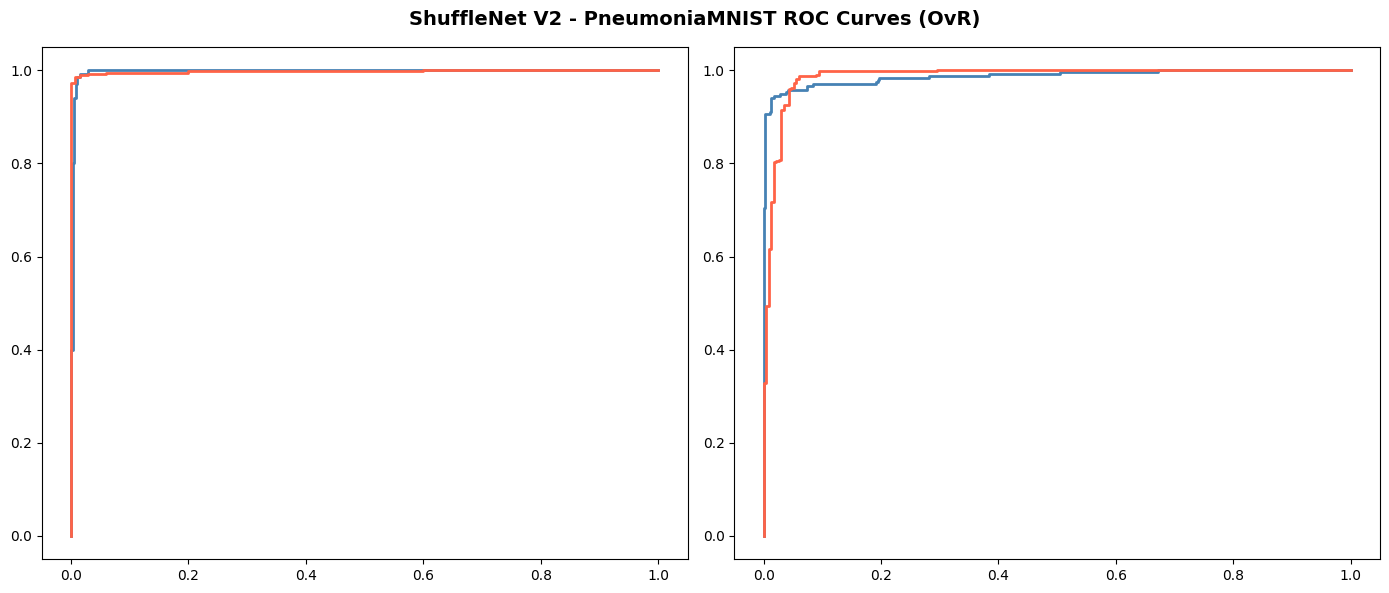

In [18]:
palette = ["steelblue", "tomato"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"{cfg.MODEL_NAME} - PneumoniaMNIST ROC Curves (OvR)", fontsize=14, fontweight="bold")
for ax, (probs, labels, title) in zip(axes, [
        (val_probs, val_labels, "Validation"),
        (tst_probs, tst_labels, "Test")]):

    lb = label_binarize(labels, classes=list(range(cfg.NUM_CLASSES)))

    # Fix for binary classification: label_binarize returns shape (n,1)
    if cfg.NUM_CLASSES == 2:
        lb = np.hstack([1 - lb, lb])  # make it (n, 2)

    for i, (cls, color) in enumerate(zip(cfg.CLASS_NAMES, palette)):
        fpr, tpr, _ = roc_curve(lb[:, i], probs[:, i])
        ax.plot(fpr, tpr, color=color, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.3f})")
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_roc_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Per-Class Metrics Comparison

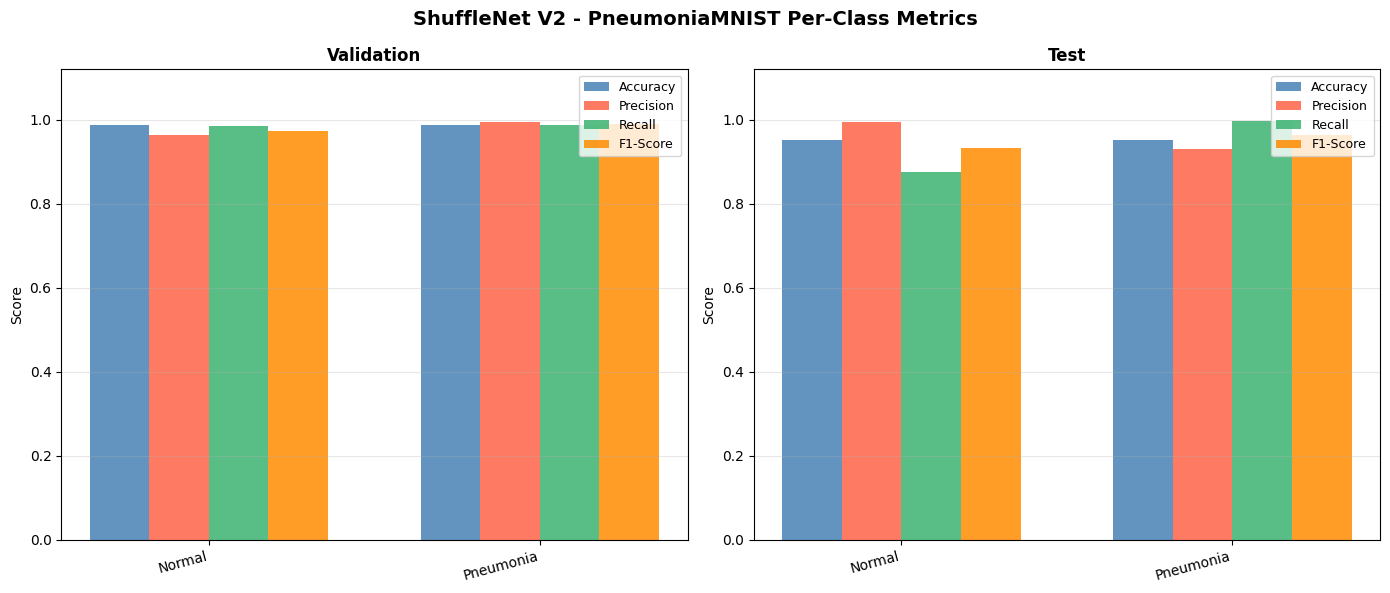

In [16]:
metrics_list = ["Accuracy", "Precision", "Recall", "F1-Score"]
mc = ["steelblue", "tomato", "mediumseagreen", "darkorange"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f"{cfg.MODEL_NAME} - PneumoniaMNIST Per-Class Metrics", fontsize=14, fontweight="bold")
for ax, split in zip(axes, ["Validation", "Test"]):
    sub = reports_df[reports_df["Split"] == split]
    x = np.arange(len(cfg.CLASS_NAMES)); w = 0.18
    for j, (met, col) in enumerate(zip(metrics_list, mc)):
        vals = [sub.loc[sub["Class"]==cls, met].values[0] for cls in cfg.CLASS_NAMES]
        ax.bar(x + j*w, vals, w, label=met, color=col, alpha=0.85)
    ax.set_xticks(x + w*1.5); ax.set_xticklabels(cfg.SHORT_NAMES, rotation=15, ha="right")
    ax.set_ylim(0, 1.12); ax.set_ylabel("Score")
    ax.set_title(split, fontsize=12, fontweight="bold")
    ax.legend(fontsize=9); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_metrics_comparison.png"), dpi=150, bbox_inches="tight")
plt.show()


## Save & Summary

In [17]:
torch.save({
    "model_state_dict": model.state_dict(),
    "config": {"model": cfg.MODEL_NAME, "num_classes": cfg.NUM_CLASSES,
               "class_names": cfg.CLASS_NAMES, "img_size": cfg.IMG_SIZE},
    "best_val_loss": best_val_loss,
}, os.path.join(cfg.OUTPUT_DIR, f"{cfg.PREFIX}_final.pth"))

print("=" * 65)
print(f"DONE - {cfg.MODEL_NAME} PneumoniaMNIST")
print("=" * 65)
print(f"  Best Val Loss : {best_val_loss:.4f}")
print(f"  Val  Accuracy : {val_acc:.4f}")
print(f"  Test Accuracy : {tst_acc:.4f}")
print("\nPer-class F1 (Test):")
ts = reports_df[reports_df["Split"] == "Test"]
for _, r in ts.iterrows():
    print(f"  {r['Class']:20s} F1={r['F1-Score']:.4f}  Acc={r['Accuracy']:.4f}")
print("\nAll outputs saved.")


DONE - ShuffleNet V2 PneumoniaMNIST
  Best Val Loss : 0.0465
  Val  Accuracy : 0.9866
  Test Accuracy : 0.9519

Per-class F1 (Test):
  Normal               F1=0.9318  Acc=0.9519
  Pneumonia            F1=0.9629  Acc=0.9519

All outputs saved.
